<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/Find_CompProfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [222]:
import csv
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
from google.colab import files
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1D Composition Profile Plot

## Extract Data and Name Variables

In [223]:
# Experimental Data (RMC Reconstruction)
file = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/RMC_Coreshell5050_PdNi_onAu_r25_4-10-5_v1/1-10.stru"
# Reference Data File (MC Target)
file_ref = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/MC_Coreshell5050_PdNi_onAu_r25/5000_voidless.stru"
# Save file names

plotTitle = r'$Pd_{50}Ni_{50}$: 4-10-5_v1'
plotsavename_by_atom = 'Pd50Ni50_4-10-5_v1_CP_by_atom.png'
plotsavename_by_rad = 'Pd50Ni50_4-10-5_v1_CP_by_rad.png'
csvsavename_by_atom = 'Pd50Ni50_4-10-5_v1_1D_CP_by_atom.csv'
csvsavename_by_rad = 'Pd50Ni50_4-10-5_v1_1D_CP_by_rad.csv'
# Reference Atoms
atom = 'PD'         # This atom has its composition profile measured
other_atom = 'NI'   # This atom is used for Labeling Purposes

In [224]:
################################################################################
# Extract Experimental Data (RMC)
################################################################################
data = pd.read_csv(file, skiprows=3)
data = data.drop(data.columns[3:], axis=1)
data[["atoms", "x"]] = data[data.columns[0]].str.split(expand=True)
data = data.drop(data.columns[0], axis=1)
data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data = data[data.atom!='VOID']        # Removes all voids
data["x"] = data["x"].astype(float)
data["y"] = data["y"].astype(float)
data["z"] = data["z"].astype(float)
data["distance"] = np.sqrt((data["x"]*data["x"] + data["y"]*data["y"] + data["z"]*data["z"])*(4.0789*4.0789))
# Output relevant structural info
print("Max distance in angstroms "+str(round(data["distance"].max(),5)) +" - RMC Data")
print("Min distance in angstroms "+str(round(data["distance"].min(),5)) +" - RMC Data")
################################################################################
# Extract Reference Data (MMC)
################################################################################
data_ref = pd.read_csv(file_ref, skiprows=3)
data_ref = data_ref.drop(data_ref.columns[3:], axis=1)
data_ref[["atoms", "x"]] = data_ref[data_ref.columns[0]].str.split(expand=True)
data_ref = data_ref.drop(data_ref.columns[0], axis=1)
data_ref = data_ref.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data_ref = data_ref[data_ref.atom!='VOID']
data_ref["x"] = data_ref["x"].astype(float)
data_ref["y"] = data_ref["y"].astype(float)
data_ref["z"] = data_ref["z"].astype(float)
data_ref["distance"] = np.sqrt((data_ref["x"]*data_ref["x"] + data_ref["y"]*data_ref["y"] + data_ref["z"]*data_ref["z"])*(4.0789*4.0789))
# Output relevant structural info
print("Max distance in angstroms "+str(round(data_ref["distance"].max(),5)) +" - MC Ref")
print("Min distance in angstroms "+str(round(data_ref["distance"].min(),5)) +" - MC Ref")

<ipython-input-224-2d8dcb128769>:8: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


Max distance in angstroms 26.049 - RMC Data
Min distance in angstroms 0.41789 - RMC Data
Max distance in angstroms 23.70818 - MC Ref
Min distance in angstroms 0.09983 - MC Ref


<ipython-input-224-2d8dcb128769>:24: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data_ref = data_ref.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


### Bin Data by Similar Number of Atoms

In [225]:
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
################################################################################
# Make bins sizes based off of maximum radius
RMC_Bins = []
MMC_Bins = []
RMC_other_counts = []
RMC_atom_counts = []
MMC_other_counts = []
MMC_atom_counts = []
for i in range(25):
    RMC_temp = data.nsmallest(157*(i+1), "distance")[-157:]
    MMC_temp = data_ref.nsmallest(157*(i+1), "distance")[-157:]

    RMC_Bins.append(RMC_temp["distance"].mean())
    MMC_Bins.append(MMC_temp["distance"].mean())

    RMC_atom_count = len(RMC_temp[RMC_temp["atom"]==atom])
    RMC_other_count = len(RMC_temp[RMC_temp["atom"]!=atom])
    MMC_atom_count = len(MMC_temp[MMC_temp["atom"]==atom])
    MMC_other_count = len(MMC_temp[MMC_temp["atom"]!=atom])

    RMC_atom_counts.append(RMC_atom_count/(len(RMC_temp)))
    RMC_other_counts.append(RMC_other_count/(len(RMC_temp)))
    MMC_atom_counts.append(MMC_atom_count/(len(MMC_temp)))
    MMC_other_counts.append(MMC_other_count/(len(MMC_temp)))

### Bin Data by Radial Distance

In [226]:
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
################################################################################
# Make bins sizes based off of custom max radius
numbin = 15

realBins = np.around(np.linspace(0,26,numbin),decimals=2)

data["bin"] = pd.cut(data["distance"], bins=realBins, right=False, precision=2,include_lowest='True',labels=realBins[1:])
data["bin"] = data["bin"].astype(float)
data_ref["bin"] = pd.cut(data_ref["distance"], bins=realBins, right=False, precision=2,include_lowest='True',labels=realBins[1:])
data_ref["bin"] = data_ref["bin"].astype(float)
data = data[["atom","x","y","z","distance","bin"]]
data_ref = data_ref[["atom","x","y","z","distance","bin"]]
################################################################################
# Group atom type by bin in order to plot
################################################################################
data_grouped = (data.groupby("bin")["atom"].value_counts(normalize=True).unstack()).fillna(0)
data_ref_grouped = (data_ref.groupby("bin")["atom"].value_counts(normalize=True).unstack()).fillna(0)
################################################################################
# Output atom/bin grouping info to reference
################################################################################
print("RMC DATA")
print("BIN     #Atoms")
print(data.bin.value_counts())
print("MC DATA")
print("BIN     #Atoms")
print(data_ref.bin.value_counts())

RMC DATA
BIN     #Atoms
24.14    770
22.29    704
20.43    566
18.57    474
16.71    344
14.86    273
26.00    223
13.00    213
11.14    156
9.29      98
7.43      58
5.57      31
3.71      12
1.86       1
Name: bin, dtype: int64
MC DATA
BIN     #Atoms
22.29    838
24.14    654
20.43    630
18.57    520
16.71    347
14.86    326
13.00    231
11.14    157
9.29      95
7.43      75
5.57      38
3.71      13
1.86       1
Name: bin, dtype: int64


## Make Composition Profile Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

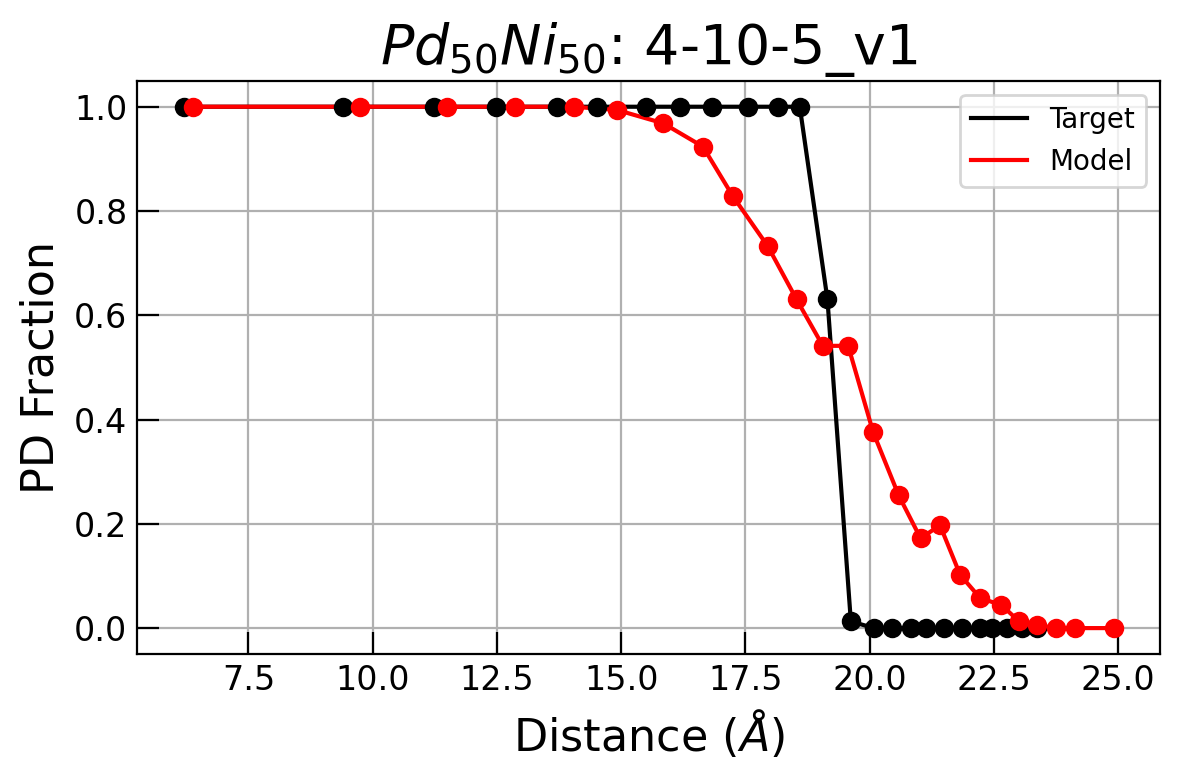

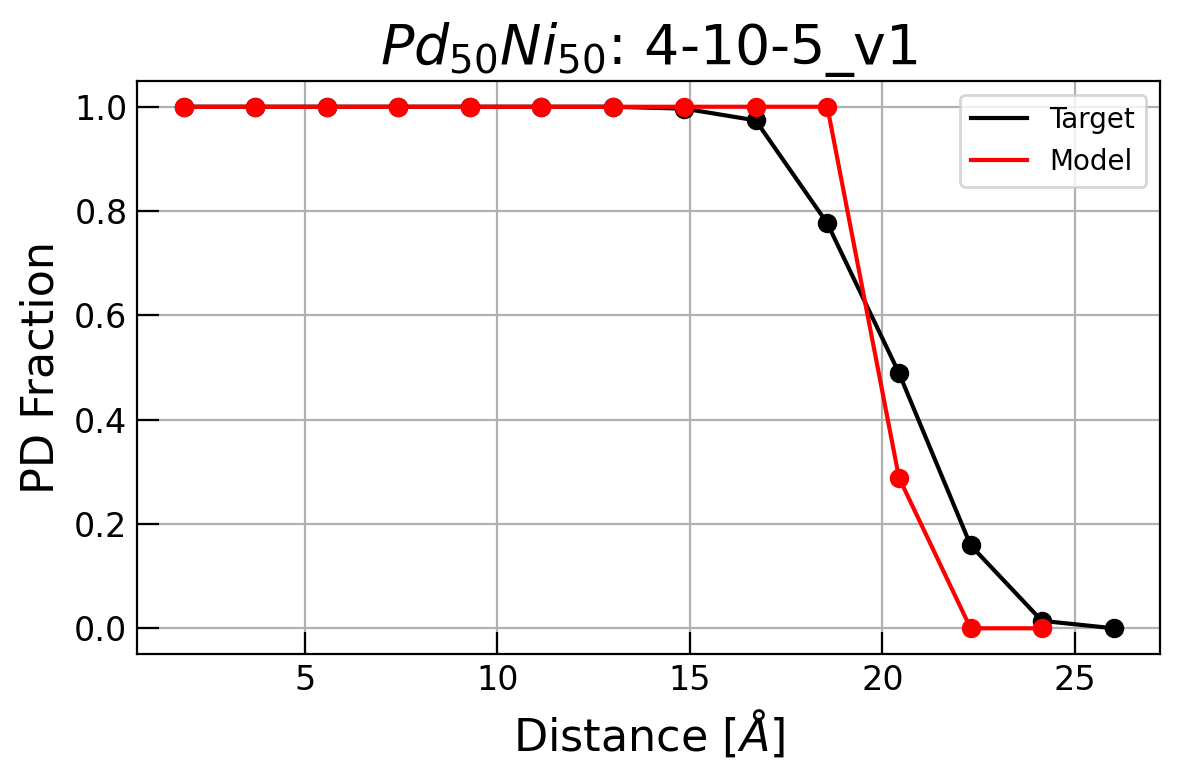

In [227]:
################################################################################
# Plot Data by Atom
################################################################################
fig1, ax1 = plt.subplots(figsize=(6,4,),dpi=200)
ax1.plot(MMC_Bins,MMC_atom_counts, color='black', label = "Target", zorder=1)
ax1.plot(RMC_Bins,RMC_atom_counts, color='red', label = "Model", zorder=1)
ax1.scatter(MMC_Bins,MMC_atom_counts, color='black', zorder=2)
ax1.scatter(RMC_Bins,RMC_atom_counts, color='red', zorder=2)
################################################################################
# Plot settings
################################################################################
ax1.set_title(plotTitle, fontsize=20)
ax1.set_ylabel(atom+" Fraction", fontsize=16)
ax1.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax1.set_xlabel(r'Distance ($\AA$)', fontsize=16)
ax1.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax1.legend()
ax1.grid(True)
ax1.set_axisbelow(True)
plt.tight_layout()
fig1.savefig(plotsavename_by_atom)
files.download(plotsavename_by_atom)
################################################################################
# Plot Data by Rad
################################################################################
fig2, ax2 = plt.subplots(figsize=(6,4,),dpi=200)
ax2.plot(realBins[1:len(data_grouped[atom])+1],data_grouped[atom], color='black', label = "Target", zorder=1)
ax2.plot(realBins[1:len(data_ref_grouped[atom])+1],data_ref_grouped[atom], color='red', label = "Model", zorder=1)
ax2.scatter(realBins[1:len(data_grouped[atom])+1],data_grouped[atom], color='black', zorder=2)
ax2.scatter(realBins[1:len(data_ref_grouped[atom])+1],data_ref_grouped[atom], color='red', zorder=2)
################################################################################
# Plot settings
################################################################################
ax2.set_title(plotTitle, fontsize=20)
ax2.set_ylabel(atom+" Fraction", fontsize=16)
ax2.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax2.set_xlabel(r'Distance [$\AA$]', fontsize=16)
ax2.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax2.legend()
ax2.grid(True)
ax2.set_axisbelow(True)
plt.tight_layout()
# Uncomment to save and download plots
fig2.savefig(plotsavename_by_rad)
files.download(plotsavename_by_rad)

## Output Data as a csv file

In [228]:
# 4 new variables used for naming csv export file coulmn headers
csv_MMC_atom_counts = 'MMC_'+ atom +'_counts'
csv_MMC_other_atom_counts = 'MMC_'+ other_atom +'_counts'
csv_RMC_atom_counts = 'RMC_'+ atom +'_counts'
csv_RMC_other_atom_counts = 'RMC_'+ other_atom +'_counts'

column_values = ['RMC_Bins', csv_RMC_atom_counts, csv_RMC_other_atom_counts, 'MMC_Bins', csv_MMC_atom_counts, csv_MMC_other_atom_counts]
by_atom = pd.DataFrame(data = np.transpose([RMC_Bins, RMC_atom_counts, RMC_other_counts, MMC_Bins, MMC_atom_counts, MMC_other_counts]), columns = column_values)
by_atom

,RMC_Bins,RMC_PD_counts,RMC_NI_counts,MMC_Bins,MMC_PD_counts,MMC_NI_counts
0,6.379867,1.000000,0.000000,6.196565,1.000000,0.000000
1,9.739404,1.000000,0.000000,9.407427,1.000000,0.000000
2,11.486079,1.000000,0.000000,11.242150,1.000000,0.000000
3,12.860146,1.000000,0.000000,12.485247,1.000000,0.000000
4,14.042644,1.000000,0.000000,13.712459,1.000000,0.000000
5,14.923194,0.993631,0.006369,14.505015,1.000000,0.000000
6,15.848772,0.968153,0.031847,15.501664,1.000000,0.000000
7,16.644853,0.923567,0.076433,16.178426,1.000000,0.000000
8,17.251038,0.828025,0.171975,16.831753,1.000000,0.000000
9,17.951584,0.732484,0.267516,17.544297,1.000000,0.000000


In [229]:
data_ref_grouped

atom,NI,PD
bin,,
1.86,0.000000,1.000000
3.71,0.000000,1.000000
5.57,0.000000,1.000000
7.43,0.000000,1.000000
9.29,0.000000,1.000000
11.14,0.000000,1.000000
13.00,0.000000,1.000000
14.86,0.000000,1.000000
16.71,0.000000,1.000000


In [230]:
by_atom.to_csv(csvsavename_by_atom)
data_grouped.to_csv(csvsavename_by_rad)
files.download(csvsavename_by_atom)
files.download(csvsavename_by_rad)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2D Composition Profile Plot

## Extract and Format Data

In [231]:
# 3D bin space
numbin = 25

In [232]:
################################################################################
# Extract RMC Data
################################################################################
RMC_data = pd.read_csv(file, skiprows=3)
RMC_data = RMC_data.drop(RMC_data.columns[3:], axis=1)
RMC_data[["atoms", "x"]] = RMC_data[RMC_data.columns[0]].str.split(expand=True)
RMC_data = RMC_data.drop(RMC_data.columns[0], axis=1)
RMC_data = RMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
RMC_data = RMC_data[RMC_data.atom!='VOID']
################################################################################
# Format RMC Data
################################################################################
RMC_data["x"] = RMC_data["x"].astype(float)
RMC_data["y"] = RMC_data["y"].astype(float)
RMC_data["z"] = RMC_data["z"].astype(float)
RMC_data["distance"] = np.sqrt((RMC_data["x"]*RMC_data["x"] + RMC_data["y"]*RMC_data["y"] + RMC_data["z"]*RMC_data["z"]))
# Output relevant structural info
print("Max distance in angstroms "+str(round(RMC_data["distance"].max(),5)) +" - RMC Data")
print("Min distance in angstroms "+str(round(RMC_data["distance"].min(),5)) +" - RMC Data")
################################################################################
# Extract MMC Data
################################################################################
MMC_data = pd.read_csv(file_ref, skiprows=3)
MMC_data = MMC_data.drop(MMC_data.columns[3:], axis=1)
MMC_data[["atoms", "x"]] = MMC_data[MMC_data.columns[0]].str.split(expand=True)
MMC_data = MMC_data.drop(MMC_data.columns[0], axis=1)
MMC_data = MMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
MMC_data = MMC_data[MMC_data.atom!='VOID']
################################################################################
# Format MMC Data
################################################################################
MMC_data["x"] = MMC_data["x"].astype(float)
MMC_data["y"] = MMC_data["y"].astype(float)
MMC_data["z"] = MMC_data["z"].astype(float)
MMC_data["distance"] = np.sqrt((MMC_data["x"]*MMC_data["x"] + MMC_data["y"]*MMC_data["y"] + MMC_data["z"]*MMC_data["z"]))
# Output relevant structural info
print("Max distance in angstroms "+str(round(MMC_data["distance"].max(),5)) +" - MMC Data")
print("Min distance in angstroms "+str(round(MMC_data["distance"].min(),5)) +" - MMC Data")
###############################################################################
# Bin Data
###############################################################################
realBins=[]
if RMC_data["distance"].max() > MMC_data["distance"].max():
  realBins = np.linspace(-1*RMC_data["distance"].max()-.01,RMC_data["distance"].max()+.01,numbin)
else:
  realBins = np.linspace(-1*MMC_data["distance"].max()-.01,MMC_data["distance"].max()+.01,numbin)

RMC_data["xbin"] = pd.cut(RMC_data["x"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["xbin"] = RMC_data["xbin"].astype(float);
RMC_data["ybin"] = pd.cut(RMC_data["y"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["ybin"] = RMC_data["ybin"].astype(float);
RMC_data["zbin"] = pd.cut(RMC_data["z"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["zbin"] = RMC_data["zbin"].astype(float);
RMC_data = RMC_data[["atom","x","y","z","distance","xbin","ybin","zbin"]]

MMC_data["xbin"] = pd.cut(MMC_data["x"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["xbin"] = MMC_data["xbin"].astype(float);
MMC_data["ybin"] = pd.cut(MMC_data["y"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["ybin"] = MMC_data["ybin"].astype(float);
MMC_data["zbin"] = pd.cut(MMC_data["z"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["zbin"] = MMC_data["zbin"].astype(float);
MMC_data = MMC_data[["atom","x","y","z","distance","xbin","ybin","zbin"]]

Max distance in angstroms 6.38628 - RMC Data
Min distance in angstroms 0.10245 - RMC Data
Max distance in angstroms 5.81239 - MMC Data
Min distance in angstroms 0.02448 - MMC Data


<ipython-input-232-492291849210>:8: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  RMC_data = RMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
<ipython-input-232-492291849210>:27: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  MMC_data = MMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


## Separate Data into 4 dataframes

In [233]:
RMC_data_atom = RMC_data[RMC_data["atom"] == atom]
RMC_data_other = RMC_data[RMC_data["atom"] != atom]
MMC_data_atom = MMC_data[MMC_data["atom"] == atom]
MMC_data_other = MMC_data[MMC_data["atom"] != atom]

### Convert Binned Data into 2D arrays (No slice through sphere)

In [234]:
MMC_atom_xy = np.zeros((numbin,numbin))
MMC_other_xy = np.zeros((numbin,numbin))
RMC_atom_xy = np.zeros((numbin,numbin))
RMC_other_xy = np.zeros((numbin,numbin))
MMC_atom_yz = np.zeros((numbin,numbin))
MMC_other_yz = np.zeros((numbin,numbin))
RMC_atom_yz = np.zeros((numbin,numbin))
RMC_other_yz = np.zeros((numbin,numbin))
MMC_atom_zx = np.zeros((numbin,numbin))
MMC_other_zx = np.zeros((numbin,numbin))
RMC_atom_zx = np.zeros((numbin,numbin))
RMC_other_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_atom_xy[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["xbin"]==i) & (MMC_data_atom["ybin"]==j)])
      MMC_other_xy[x][y] = len(MMC_data_other.loc[(MMC_data_other["xbin"]==i) & (MMC_data_other["ybin"]==j)])
      RMC_atom_xy[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["xbin"]==i) & (RMC_data_atom["ybin"]==j)])
      RMC_other_xy[x][y] = len(RMC_data_other.loc[(RMC_data_other["xbin"]==i) & (RMC_data_other["ybin"]==j)])

      MMC_atom_yz[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["ybin"]==i) & (MMC_data_atom["zbin"]==j)])
      MMC_other_yz[x][y] = len(MMC_data_other.loc[(MMC_data_other["ybin"]==i) & (MMC_data_other["zbin"]==j)])
      RMC_atom_yz[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["ybin"]==i) & (RMC_data_atom["zbin"]==j)])
      RMC_other_yz[x][y] = len(RMC_data_other.loc[(RMC_data_other["ybin"]==i) & (RMC_data_other["zbin"]==j)])

      MMC_atom_zx[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["zbin"]==i) & (MMC_data_atom["xbin"]==j)])
      MMC_other_zx[x][y] = len(MMC_data_other.loc[(MMC_data_other["zbin"]==i) & (MMC_data_other["xbin"]==j)])
      RMC_atom_zx[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["zbin"]==i) & (RMC_data_atom["xbin"]==j)])
      RMC_other_zx[x][y] = len(RMC_data_other.loc[(RMC_data_other["zbin"]==i) & (RMC_data_other["xbin"]==j)])
    except:
      None
    y+=1
  x+=1

In [235]:
diff_atom_xy = np.absolute(np.array(MMC_atom_xy) - np.array(RMC_atom_xy))
diff_atom_yz = np.absolute(np.array(MMC_atom_yz) - np.array(RMC_atom_yz))
diff_atom_zx = np.absolute(np.array(MMC_atom_zx) - np.array(RMC_atom_zx))

diff_other_xy = np.absolute(np.array(MMC_other_xy) - np.array(RMC_other_xy))
diff_other_yz = np.absolute(np.array(MMC_other_yz) - np.array(RMC_other_yz))
diff_other_zx = np.absolute(np.array(MMC_other_zx) - np.array(RMC_other_zx))

In [236]:
vmin = 0
vmax = np.array([MMC_atom_xy.max(), MMC_other_xy.max(), RMC_atom_xy.max(), RMC_other_xy.max(), MMC_atom_yz.max(), MMC_other_yz.max(),
                 RMC_atom_yz.max(), RMC_other_yz.max(), MMC_atom_zx.max(), MMC_other_zx.max(), RMC_atom_zx.max(), RMC_other_zx.max()]).max()
print(vmax)

27.0


### Plot Binned Data

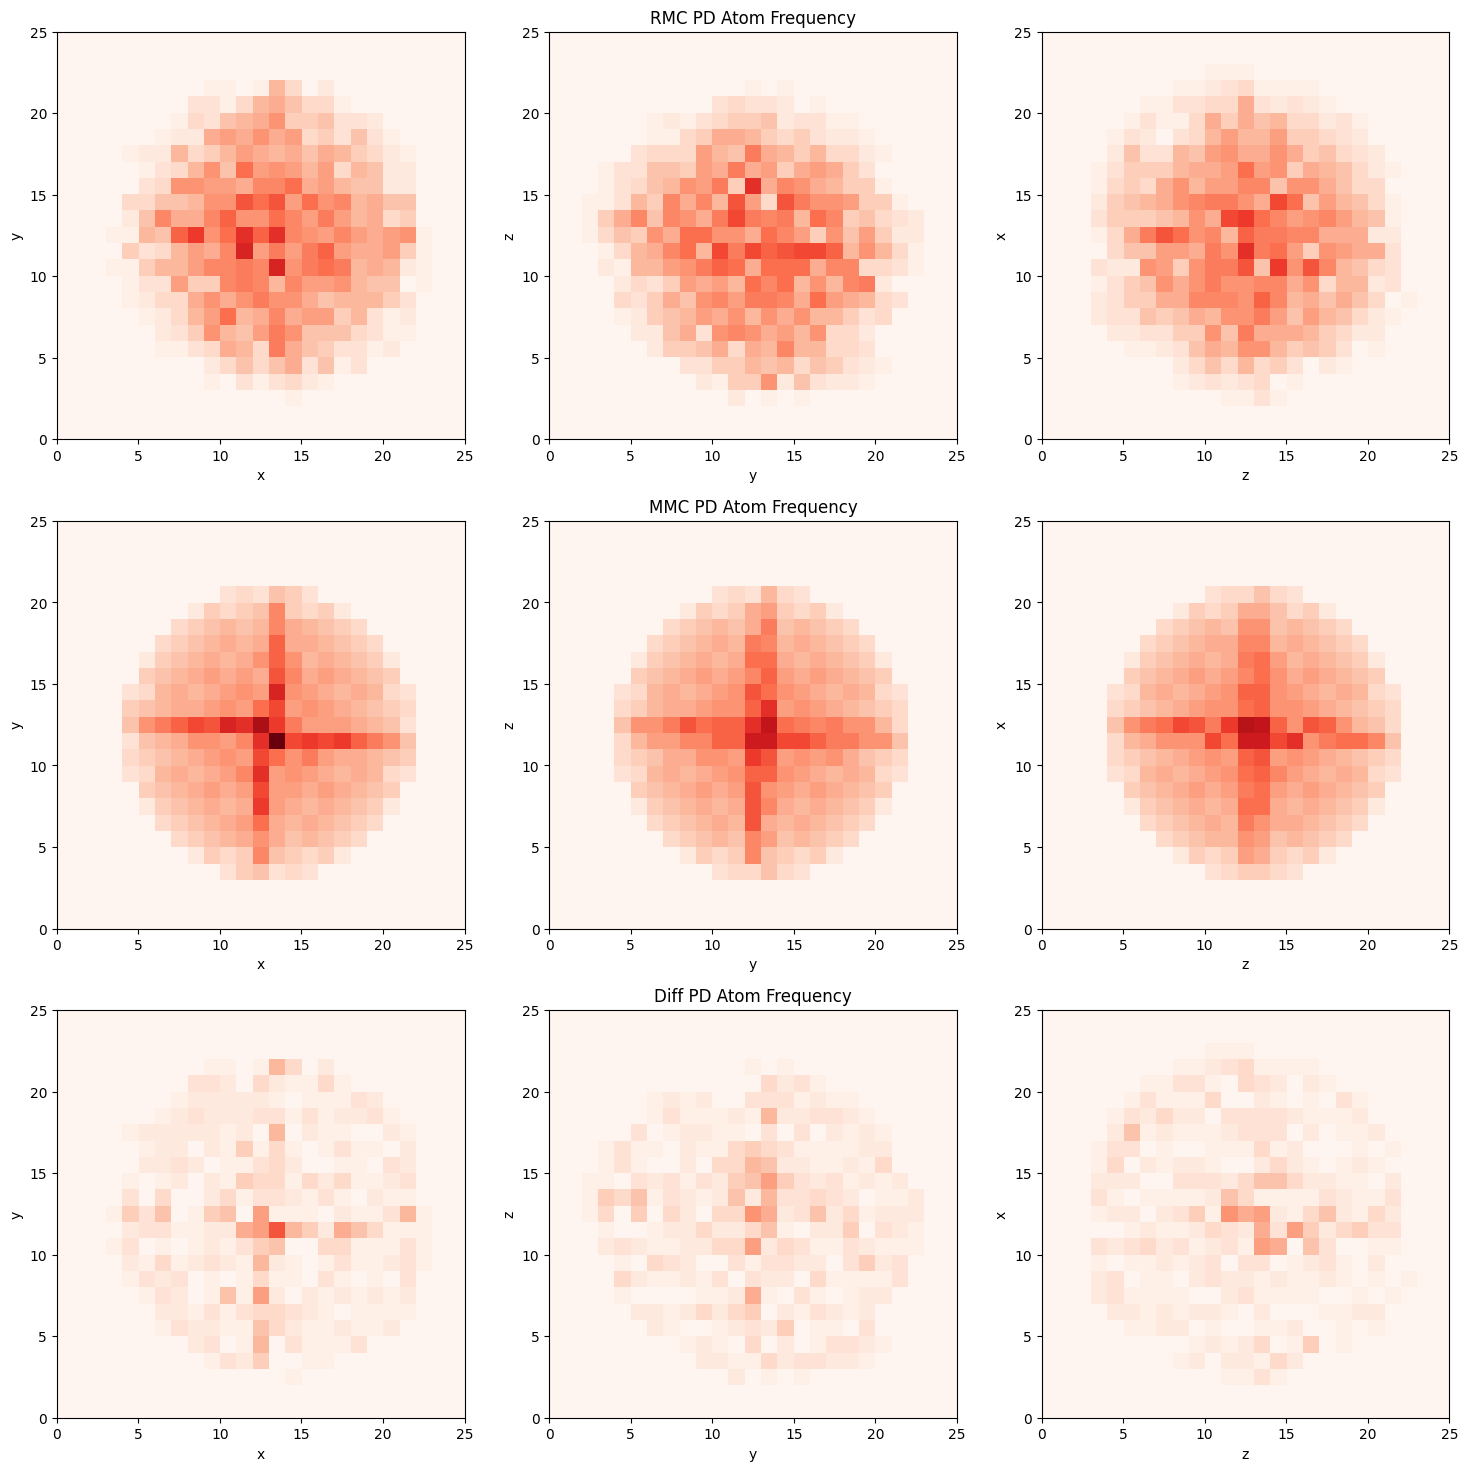

In [237]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[0,1].set_title("RMC "+atom+" Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[1,1].set_title("MMC "+atom+" Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[2,1].set_title("Diff "+atom+" Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

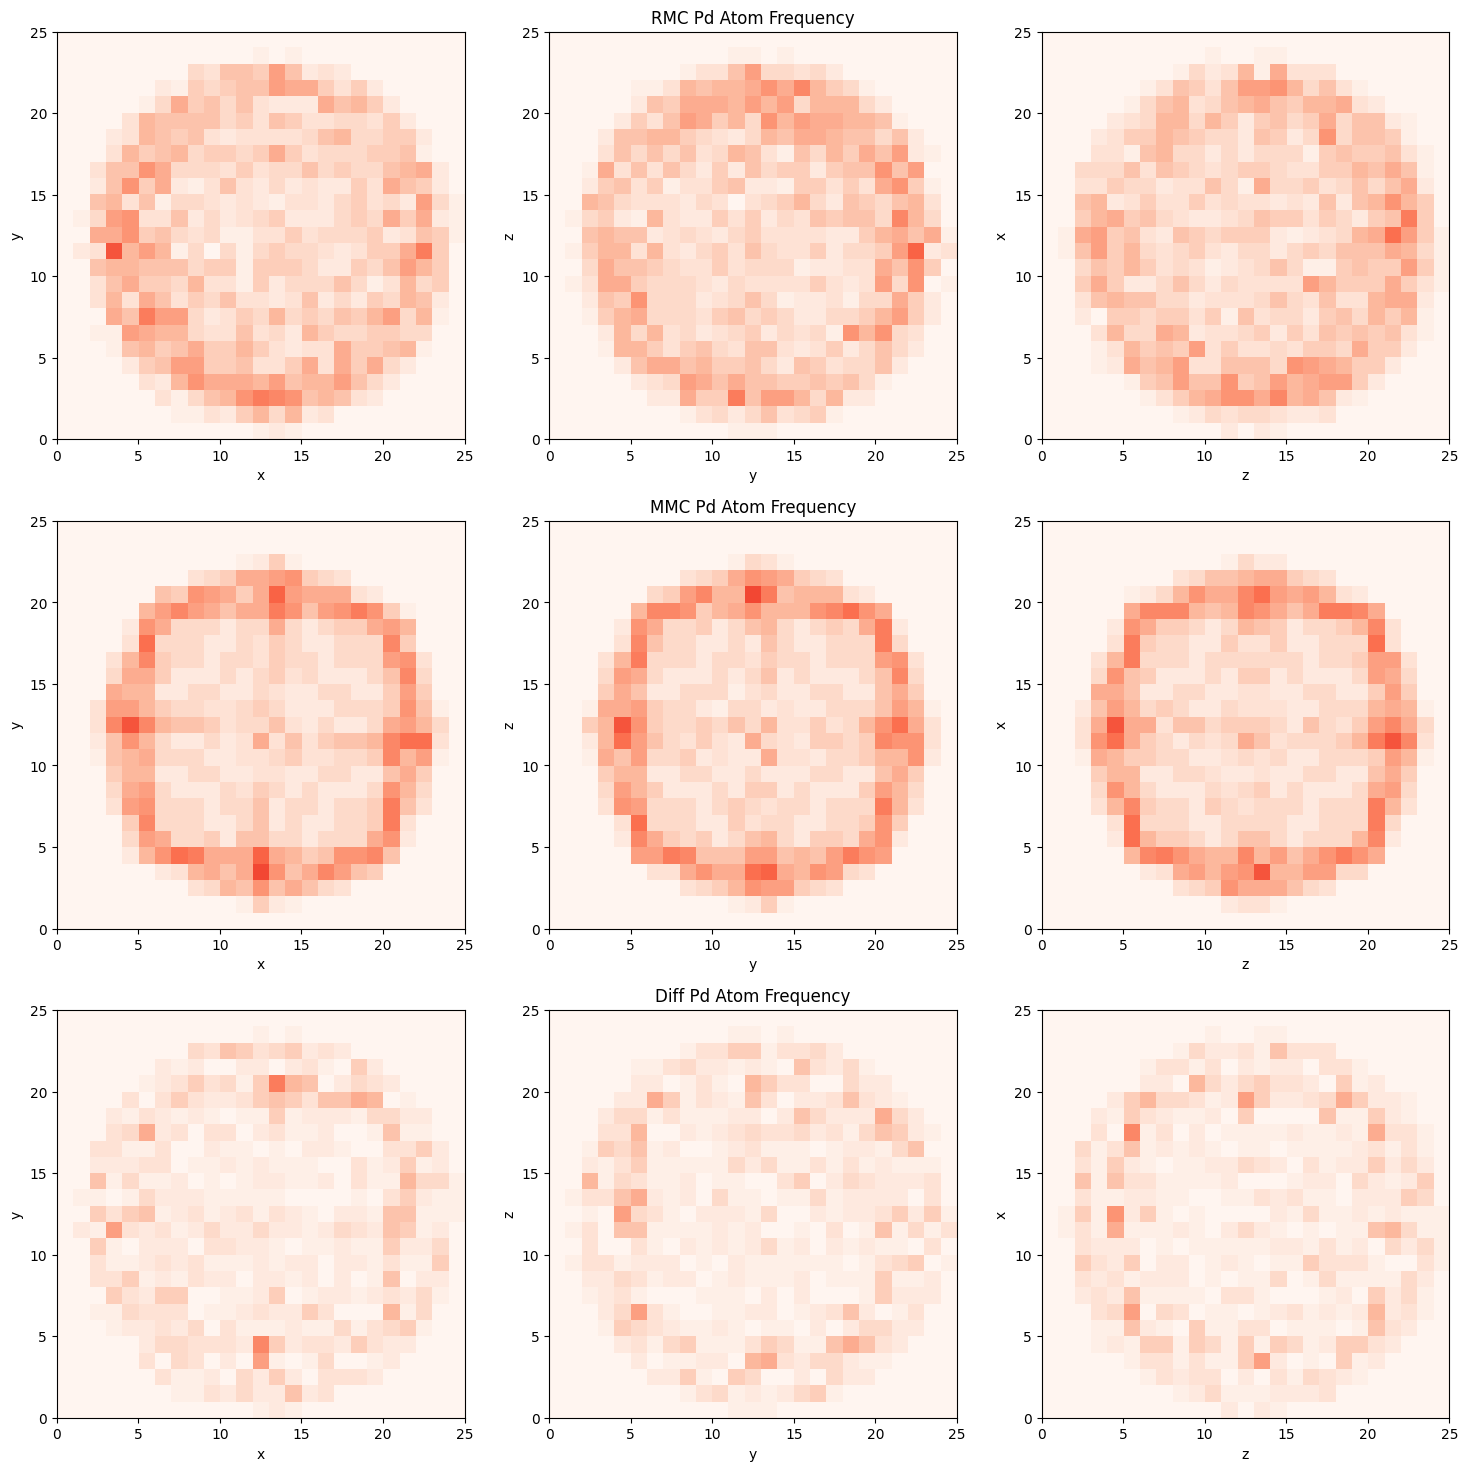

In [238]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[0,1].set_title("RMC Pd Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[1,1].set_title("MMC Pd Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_other_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[2,1].set_title("Diff Pd Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_other_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_other_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

### Convert Binned Data into 2D arrays (With Slice through sphere)

In [239]:
MMC_atom_xy = np.zeros((numbin,numbin))
MMC_other_xy = np.zeros((numbin,numbin))
RMC_atom_xy = np.zeros((numbin,numbin))
RMC_other_xy = np.zeros((numbin,numbin))
MMC_atom_yz = np.zeros((numbin,numbin))
MMC_other_yz = np.zeros((numbin,numbin))
RMC_atom_yz = np.zeros((numbin,numbin))
RMC_other_yz = np.zeros((numbin,numbin))
MMC_atom_zx = np.zeros((numbin,numbin))
MMC_other_zx = np.zeros((numbin,numbin))
RMC_atom_zx = np.zeros((numbin,numbin))
RMC_other_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_atom_xy[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["xbin"]==i) & (MMC_data_atom["ybin"]==j) & (MMC_data_atom["zbin"]<1) & (MMC_data_atom["zbin"]>-1)])
      MMC_other_xy[x][y] = len(MMC_data_other.loc[(MMC_data_other["xbin"]==i) & (MMC_data_other["ybin"]==j) & (MMC_data_other["zbin"]<1) & (MMC_data_other["zbin"]>-1)])
      RMC_atom_xy[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["xbin"]==i) & (RMC_data_atom["ybin"]==j) & (MMC_data_atom["zbin"]<1) & (MMC_data_atom["zbin"]>-1)])
      RMC_other_xy[x][y] = len(RMC_data_other.loc[(RMC_data_other["xbin"]==i) & (RMC_data_other["ybin"]==j) & (MMC_data_other["zbin"]<1) & (MMC_data_other["zbin"]>-1)])

      MMC_atom_yz[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["ybin"]==i) & (MMC_data_atom["zbin"]==j) & (MMC_data_atom["xbin"]<1) & (MMC_data_atom["xbin"]>-1)])
      MMC_other_yz[x][y] = len(MMC_data_other.loc[(MMC_data_other["ybin"]==i) & (MMC_data_other["zbin"]==j) & (MMC_data_other["xbin"]<1) & (MMC_data_other["xbin"]>-1)])
      RMC_atom_yz[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["ybin"]==i) & (RMC_data_atom["zbin"]==j) & (MMC_data_atom["xbin"]<1) & (MMC_data_atom["xbin"]>-1)])
      RMC_other_yz[x][y] = len(RMC_data_other.loc[(RMC_data_other["ybin"]==i) & (RMC_data_other["zbin"]==j) & (MMC_data_other["xbin"]<1) & (MMC_data_other["xbin"]>-1)])

      MMC_atom_zx[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["zbin"]==i) & (MMC_data_atom["xbin"]==j) & (MMC_data_atom["ybin"]<1) & (MMC_data_atom["ybin"]>-1)])
      MMC_other_zx[x][y] = len(MMC_data_other.loc[(MMC_data_other["zbin"]==i) & (MMC_data_other["xbin"]==j) & (MMC_data_other["ybin"]<1) & (MMC_data_other["ybin"]>-1)])
      RMC_atom_zx[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["zbin"]==i) & (RMC_data_atom["xbin"]==j) & (MMC_data_atom["ybin"]<1) & (MMC_data_atom["ybin"]>-1)])
      RMC_other_zx[x][y] = len(RMC_data_other.loc[(RMC_data_other["zbin"]==i) & (RMC_data_other["xbin"]==j) & (MMC_data_other["ybin"]<1) & (MMC_data_other["ybin"]>-1)])
    except:
      None
    y+=1
  x+=1

In [240]:
diff_atom_xy = np.absolute(np.array(MMC_atom_xy) - np.array(RMC_atom_xy))
diff_atom_yz = np.absolute(np.array(MMC_atom_yz) - np.array(RMC_atom_yz))
diff_atom_zx = np.absolute(np.array(MMC_atom_zx) - np.array(RMC_atom_zx))

diff_other_xy = np.absolute(np.array(MMC_other_xy) - np.array(RMC_other_xy))
diff_other_yz = np.absolute(np.array(MMC_other_yz) - np.array(RMC_other_yz))
diff_other_zx = np.absolute(np.array(MMC_other_zx) - np.array(RMC_other_zx))

In [241]:
vmin = 0
vmax = np.array([MMC_atom_xy.max(), MMC_other_xy.max(), RMC_atom_xy.max(), RMC_other_xy.max(),
                 MMC_atom_yz.max(),MMC_other_yz.max(), RMC_atom_yz.max(), RMC_other_yz.max(),
                 MMC_atom_zx.max(), MMC_other_zx.max(), RMC_atom_zx.max(), RMC_other_zx.max()]).max()
print(vmax)

7.0


### Plot Binned Data (Frequency Plots)

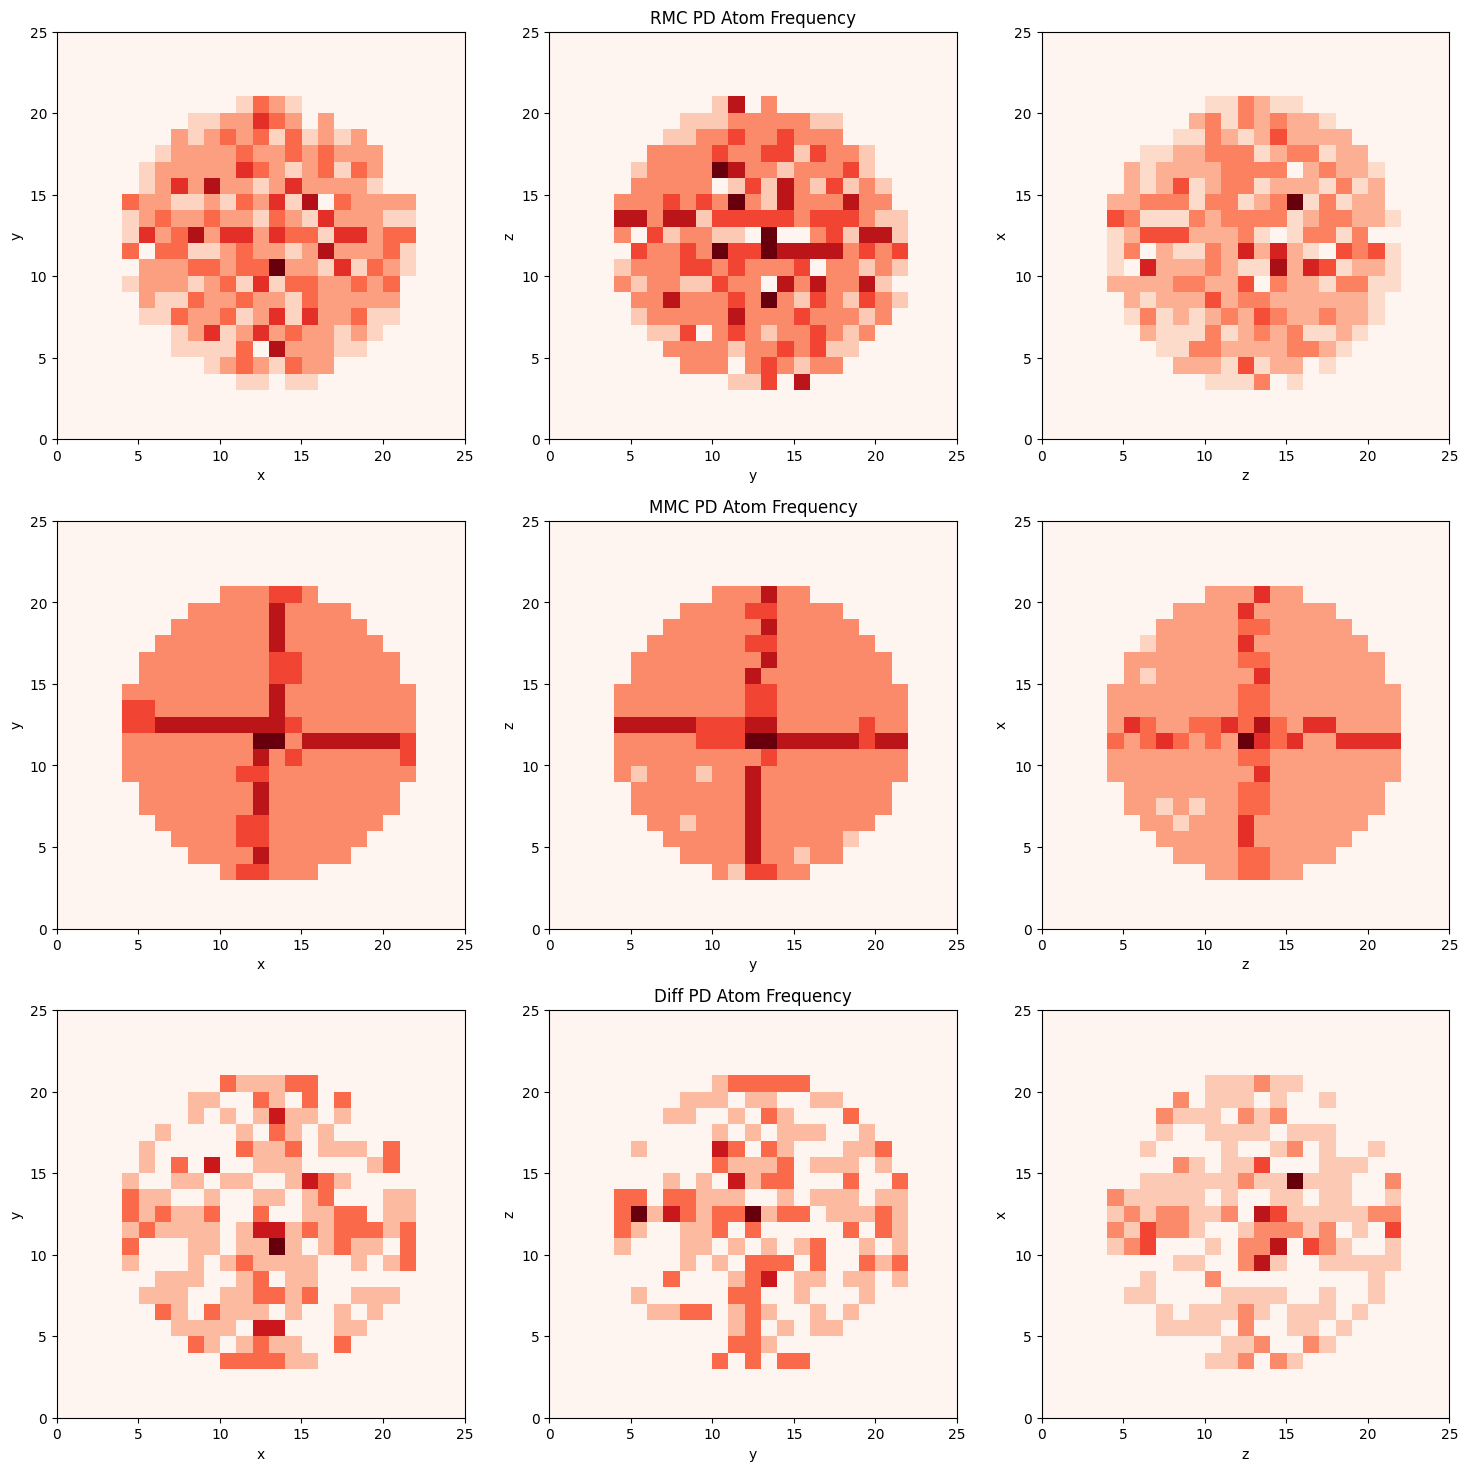

In [242]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[0,1].set_title("RMC "+atom+" Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[1,1].set_title("MMC "+atom+" Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[2,1].set_title("Diff "+atom+" Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

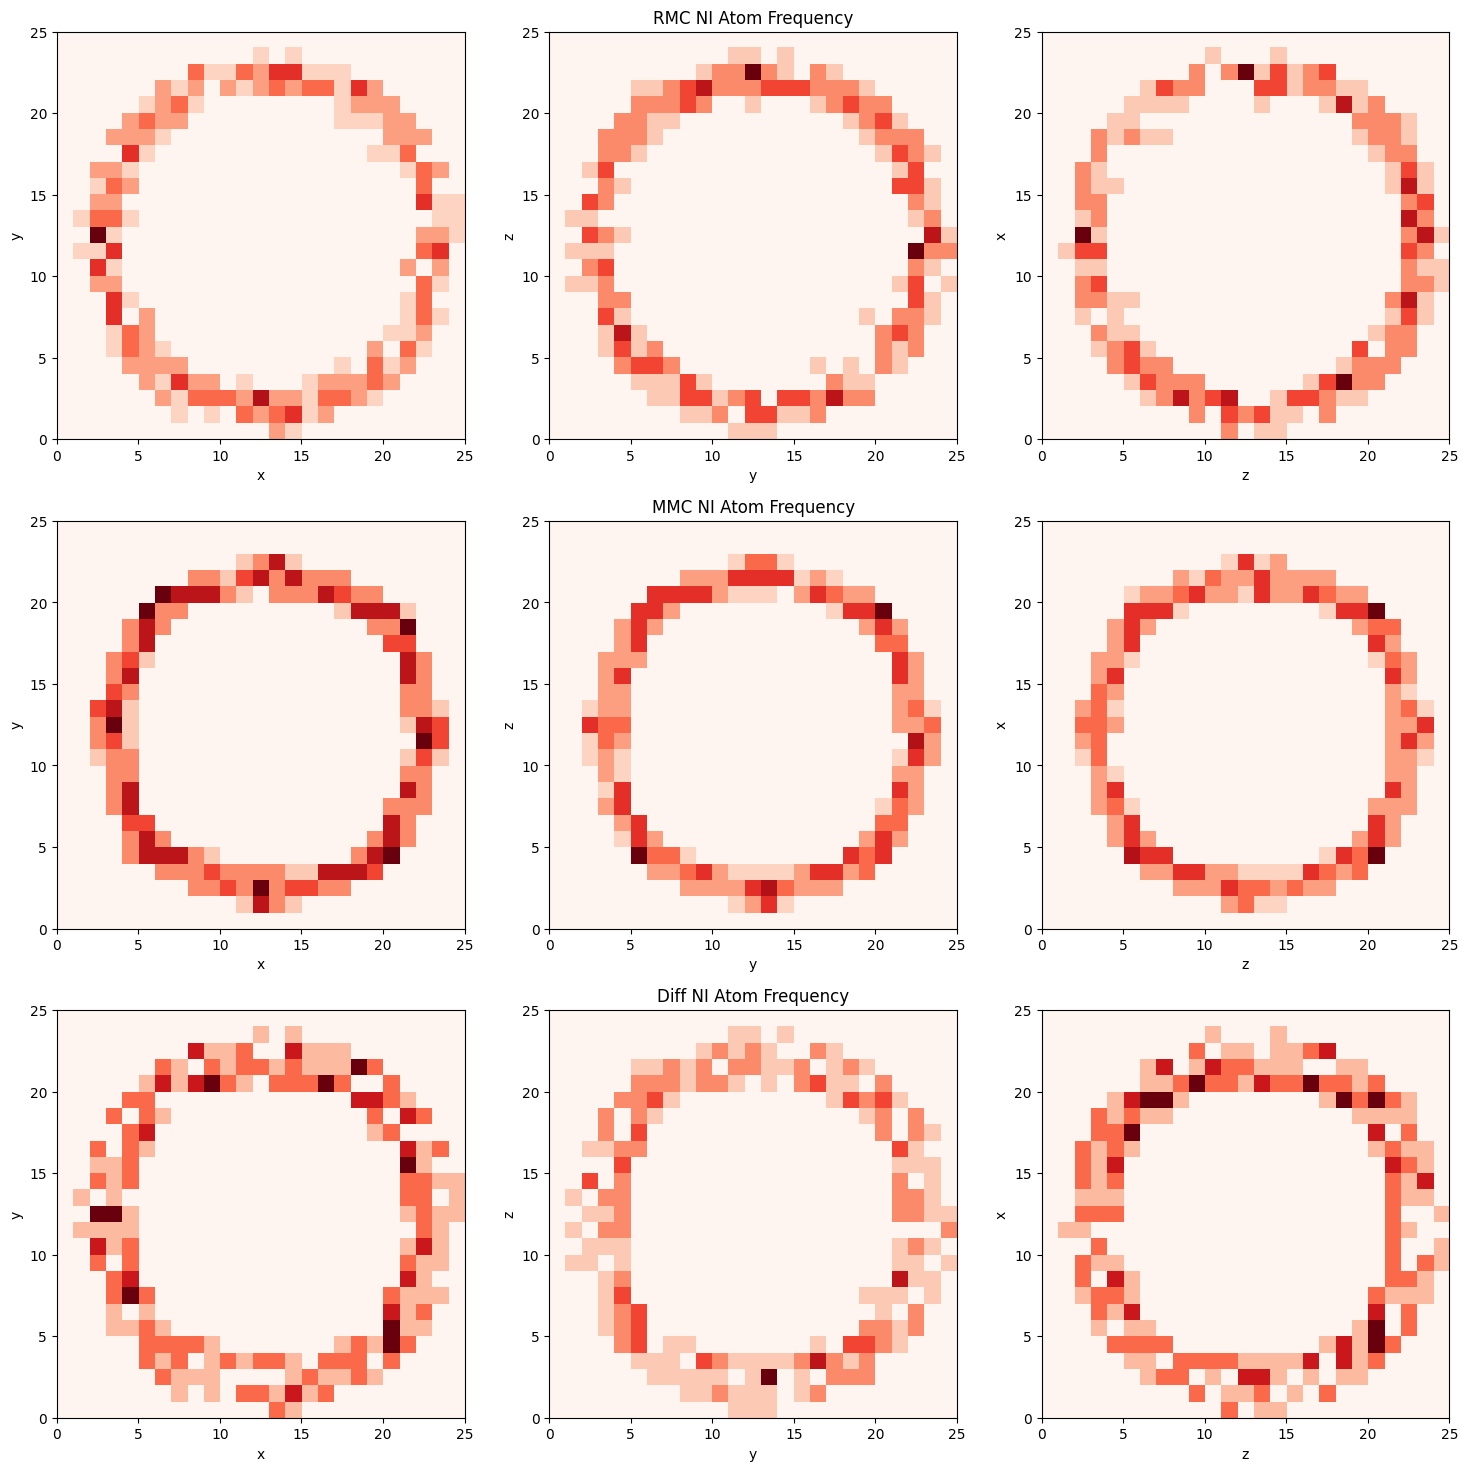

In [243]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[0,1].set_title("RMC "+other_atom+" Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[1,1].set_title("MMC "+other_atom+" Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_other_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[2,1].set_title("Diff "+other_atom+" Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_other_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_other_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

## 2D Composition Plot

Indicates the composition of the reconstructed sphere through the volume that each 2D bin corresponds to

### Convert Binned Data ino 2D Arrays

In [244]:
###############################################################################
# Format's Data into arrays that contain the Au fraction in the appropriate
# channel/bin then normalizes about 0. (i.e. -.5 means all Pd whereas +.5 means all Au)
###############################################################################
MMC_xy = np.zeros((numbin,numbin))
RMC_xy = np.zeros((numbin,numbin))
MMC_yz = np.zeros((numbin,numbin))
RMC_yz = np.zeros((numbin,numbin))
MMC_zx = np.zeros((numbin,numbin))
RMC_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_xy[x][y] = len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["atom"]==atom)]) / len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j)])-0.5
      RMC_xy[x][y] = len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["atom"]==atom)]) / len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j)])-0.5

      MMC_yz[x][y] = len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["atom"]==atom)]) / len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j)])-0.5
      RMC_yz[x][y] = len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["atom"]==atom)]) / len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j)])-0.5

      MMC_zx[x][y] = len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["atom"]==atom)]) / len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j)])-0.5
      RMC_zx[x][y] = len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["atom"]==atom)]) / len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j)])-0.5
    except:
      None
    y+=1
  x+=1
###############################################################################
# Finds the difference between the RMC and MMC Au fractions
###############################################################################
diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

### Plot Binned Data

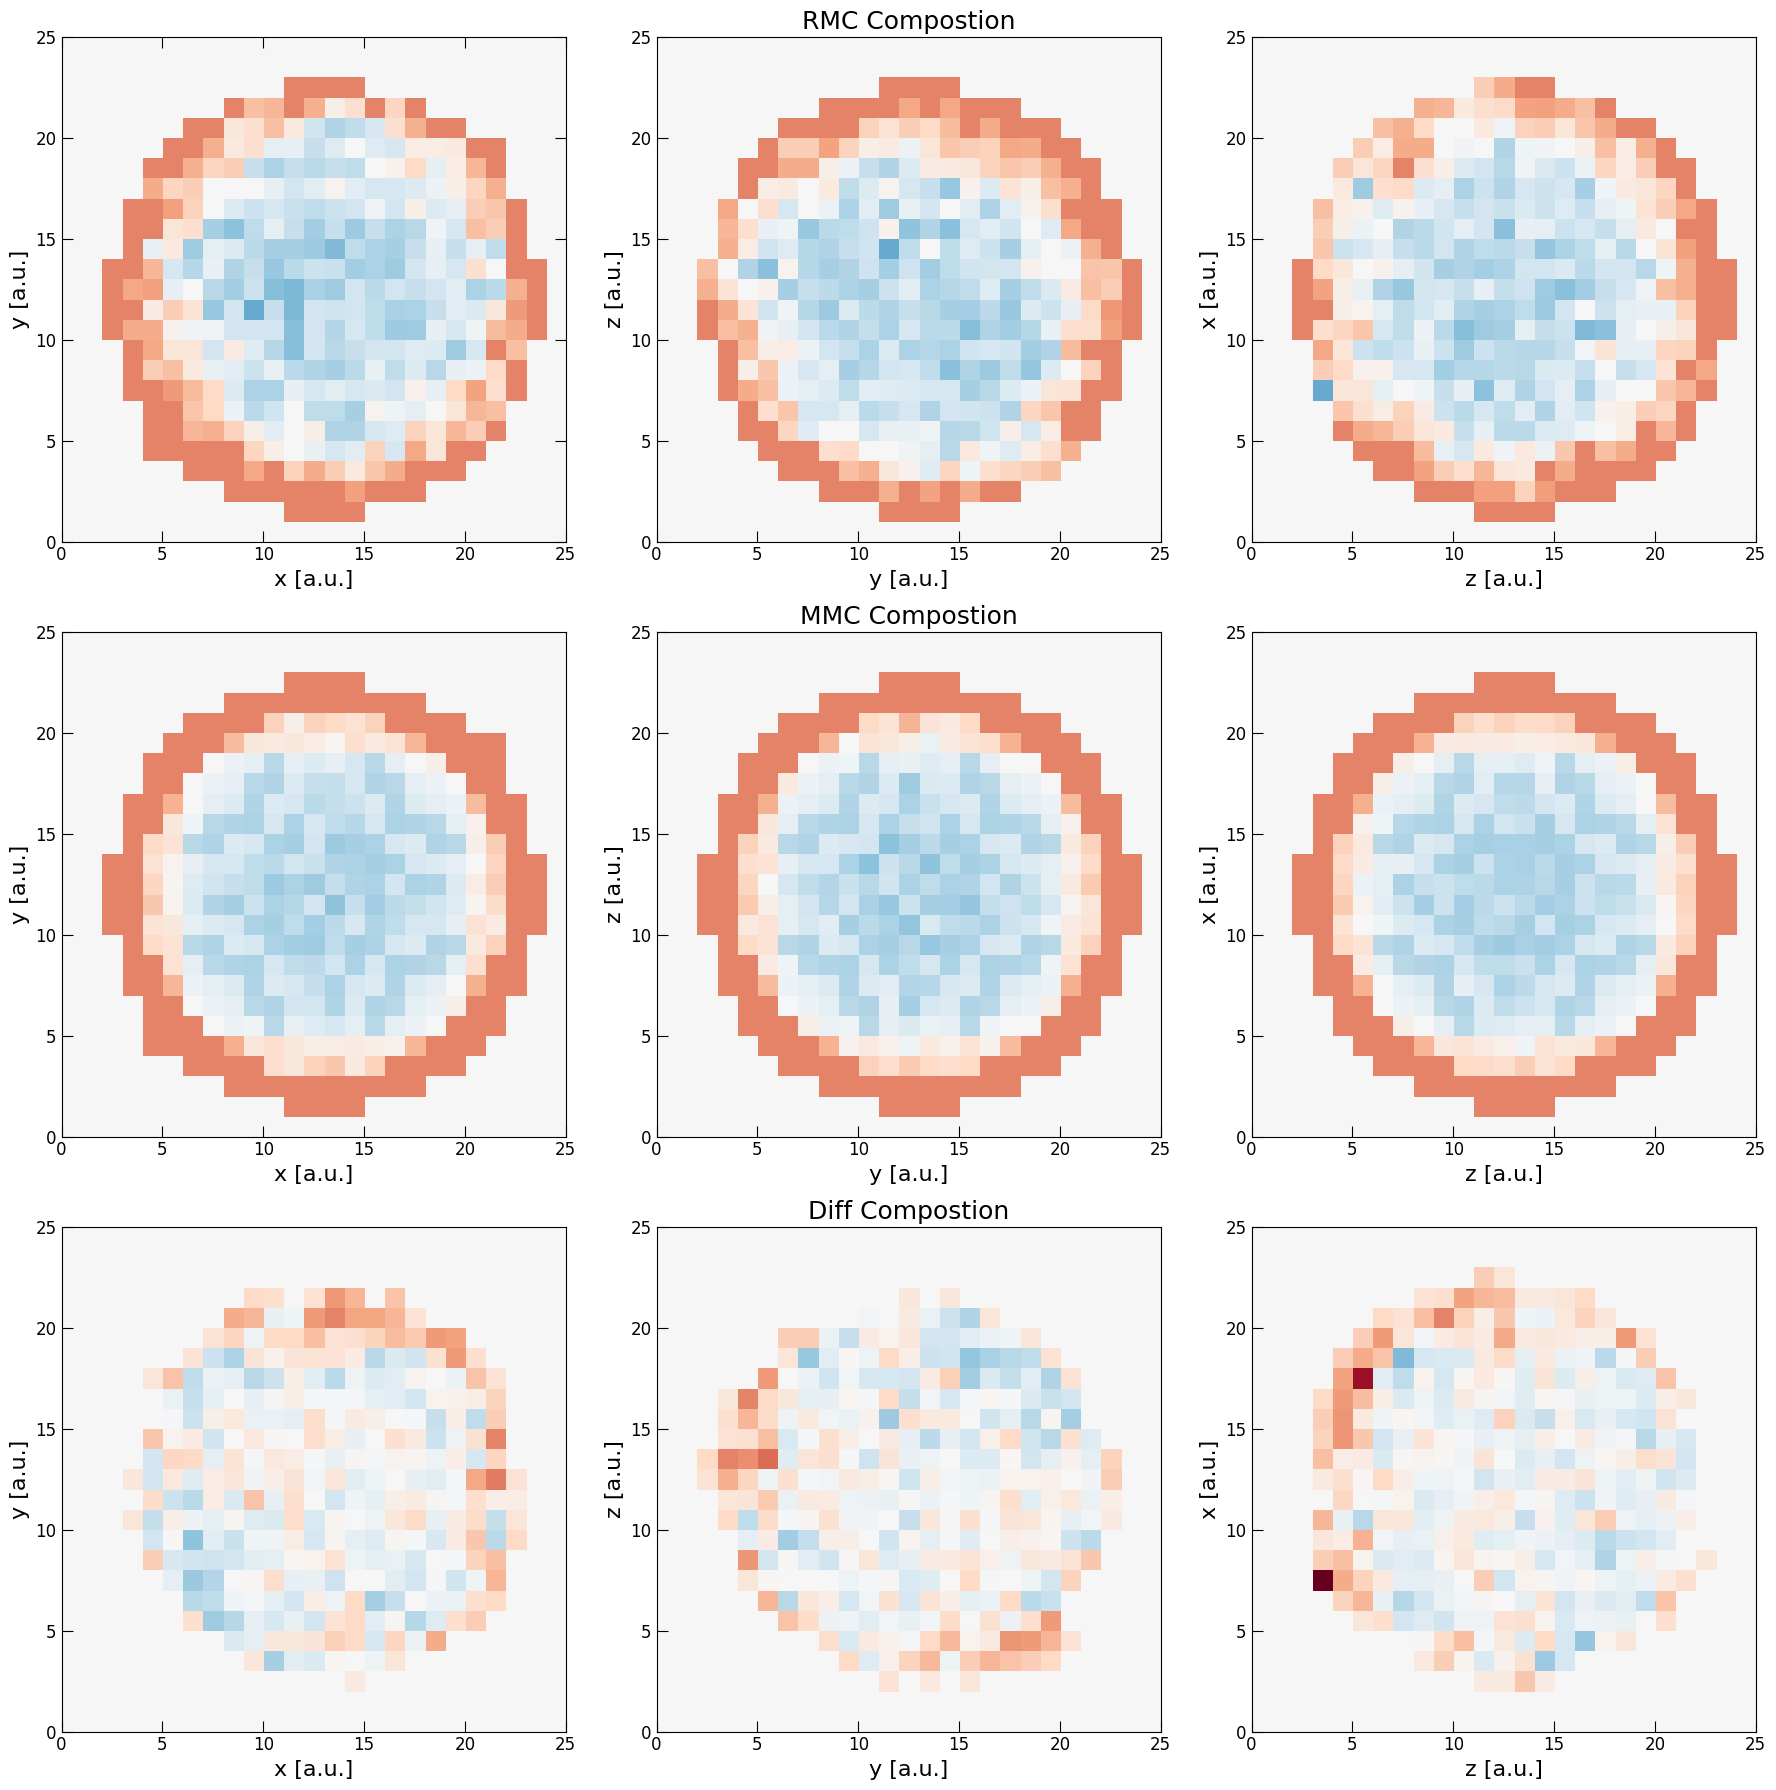

In [245]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
###
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x [a.u.]", fontsize=16)
axs[0,0].set_ylabel("y [a.u.]", fontsize=16)
axs[0,0].tick_params(bottom=True, top=True, left=True, right=True)
axs[0,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,0].imshow(RMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[0,1].set_title("RMC Compostion", fontsize=18)
axs[0,1].set_xlabel("y [a.u.]", fontsize=16)
axs[0,1].set_ylabel("z [a.u.]", fontsize=16)
axs[0,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,1].imshow(RMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z [a.u.]", fontsize=16)
axs[0,2].set_ylabel("x [a.u.]", fontsize=16)
axs[0,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,2].imshow(RMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

###
#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x [a.u.]", fontsize=16)
axs[1,0].set_ylabel("y [a.u.]", fontsize=16)
axs[1,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,0].imshow(MMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[1,1].set_title("MMC Compostion", fontsize=18)
axs[1,1].set_xlabel("y [a.u.]", fontsize=16)
axs[1,1].set_ylabel("z [a.u.]", fontsize=16)
axs[1,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,1].imshow(MMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z [a.u.]", fontsize=16)
axs[1,2].set_ylabel("x [a.u.]", fontsize=16)
axs[1,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,2].imshow(MMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

###
#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x [a.u.]", fontsize=16)
axs[2,0].set_ylabel("y [a.u.]", fontsize=16)
axs[2,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,0].imshow(diff_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[2,1].set_title("Diff Compostion", fontsize=18)
axs[2,1].set_xlabel("y [a.u.]", fontsize=16)
axs[2,1].set_ylabel("z [a.u.]", fontsize=16)
axs[2,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,1].imshow(diff_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z [a.u.]", fontsize=16)
axs[2,2].set_ylabel("x [a.u.]", fontsize=16)
axs[2,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,2].imshow(diff_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
plt.tight_layout()

## 2D Composition Plot of Slice

### Convert Binned Data into 2D Arrays

In [246]:
###############################################################################
# Format's Data into arrays that contain the Au fraction in the appropriate
# channel/bin then normalizes about 0. (i.e. -.5 means all Pd whereas +.5 means all Au)
###############################################################################
MMC_xy = np.zeros((numbin,numbin))
RMC_xy = np.zeros((numbin,numbin))
MMC_yz = np.zeros((numbin,numbin))
RMC_yz = np.zeros((numbin,numbin))
MMC_zx = np.zeros((numbin,numbin))
RMC_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_xy[x][y] = len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["atom"]==atom) & (MMC_data["zbin"]<1) & (MMC_data["zbin"]>-1)]) / len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["zbin"]<1) & (MMC_data["zbin"]>-1)])-0.5
      RMC_xy[x][y] = len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["atom"]==atom) & (RMC_data["zbin"]<1) & (RMC_data["zbin"]>-1)]) / len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["zbin"]<1) & (RMC_data["zbin"]>-1)])-0.5

      MMC_yz[x][y] = len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["atom"]==atom) & (MMC_data["xbin"]<1) & (MMC_data["xbin"]>-1)]) / len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["xbin"]<1) & (MMC_data["xbin"]>-1)])-0.5
      RMC_yz[x][y] = len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["atom"]==atom) & (RMC_data["xbin"]<1) & (RMC_data["xbin"]>-1)]) / len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["xbin"]<1) & (RMC_data["xbin"]>-1)])-0.5

      MMC_zx[x][y] = len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["atom"]==atom) & (MMC_data["ybin"]<1) & (MMC_data["ybin"]>-1)]) / len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["ybin"]<1) & (MMC_data["ybin"]>-1)])-0.5
      RMC_zx[x][y] = len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["atom"]==atom) & (RMC_data["ybin"]<1) & (RMC_data["ybin"]>-1)]) / len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["ybin"]<1) & (RMC_data["ybin"]>-1)])-0.5
    except:
      None
    y+=1
  x+=1
###############################################################################
# Finds the difference between the RMC and MMC Au fractions
###############################################################################
diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

### Plot Binned Data

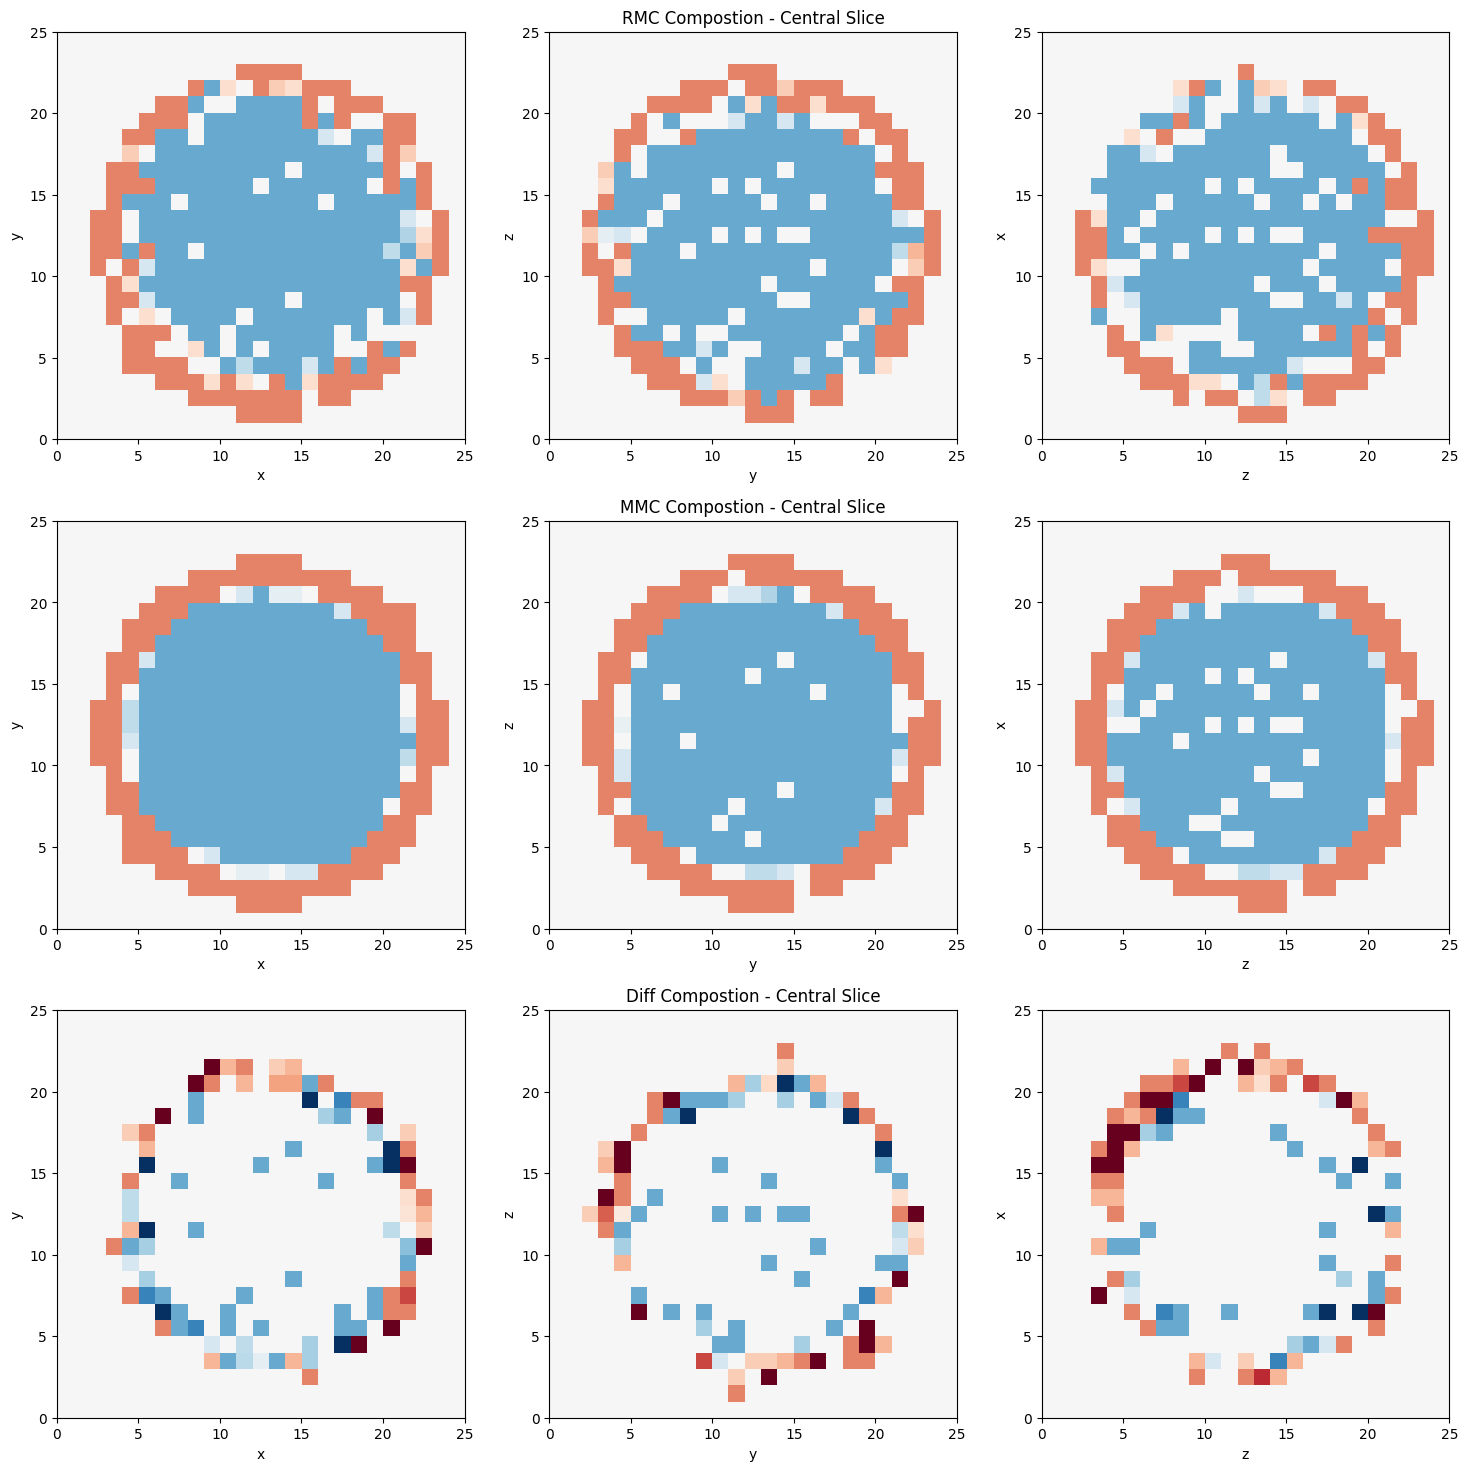

In [247]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[0,1].set_title("RMC Compostion - Central Slice")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[1,1].set_title("MMC Compostion - Central Slice")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[2,1].set_title("Diff Compostion - Central Slice")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))